In [1]:
import numpy as np
from conduction import ConductionND
from conduction.inversion import InvObservation, InvPrior
from conduction import InversionND
from petsc4py import PETSc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
minX, maxX = 0.0, 1000.0
minY, maxY = 0.0, 1000.0
minZ, maxZ = -35e3, 1000.0
nx, ny, nz = 10, 9, 10
n = nx*ny*nz

mesh = ConductionND((minX, minY, minZ), (maxX, maxY, maxZ), (nx,ny,nz))

# BCs
mesh.boundary_condition('maxZ', 298.0, flux=False)
mesh.boundary_condition('minZ', 0.04, flux=True)

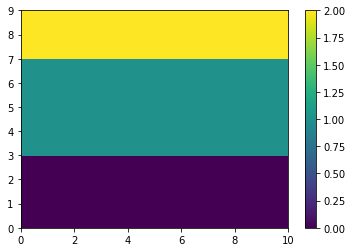

In [3]:
lithology = np.zeros((nz,ny,nx), dtype='int32')
lithology[:,3:7,:] = 1
lithology[:,7:,:]  = 2

plt.pcolor(lithology[5,:,:])
plt.colorbar()

In [4]:
def hofmeister1999(k0, T, a=0.25, c=0.0):
    return k0*(298.0/T)**a + c*T**3

def hofmeister1999_ad():
    pass

In [5]:
def forward_model(self, x, bc='Z'):
    k_list, H_list, a_list = np.array_split(x[:-1], 3)
    q0 = x[-1]
    
    # map to mesh
    k0, H, a = self.map(k_list, H_list, a_list)
    k = k0.copy()
    
    self.mesh.update_properties(k0, H)
    self.mesh.boundary_condition("max"+bc, 298.0, flux=False)
    self.mesh.boundary_condition("min"+bc, q0, flux=True)
    rhs = self.mesh.construct_rhs()
    
    error = 10.
    tolerance = 1e-5
    i = 0
    while error > tolerance:
        k_last = k.copy()
        self.mesh.diffusivity[:] = k
        T = self.linear_solve(rhs=rhs) # solve
        k = hofmeister1999(k0, T, a)
        error = np.absolute(k - k_last).max()
        i += 1
    print("{} iterations".format(i))
        
    q = self.heatflux(T, k)
    delT = self.gradient(T)
    V = np.zeros_like(H)
    P = 
    Q = np.zeros_like(H)
    for l, lith in self.lithology_index:
        idx == self.lithology_mask[l]
        (P[idx], T[idx])
    
    cost = 0.0
    cost += self.objective_routine(q=q[0], T=T, delT=delT[0]) # observations
    cost += self.objective_routine(k=k_list, H=H_list, a=a_list, q0=q0) # priors
    return cost

In [6]:
def adjoint_model(self, x, bc='Z'):
    k_list, H_list, a_list = np.array_split(x[:-1], 3)
    q0 = x[-1]
    
    # map to mesh
    k0, H, a = self.map(k_list, H_list, a_list)
    k = [k0.copy()]
    T = [None]
    
    self.mesh.update_properties(k0, H)
    self.mesh.boundary_condition("max"+bc, 298.0, flux=False)
    self.mesh.boundary_condition("min"+bc, q0, flux=True)
    rhs = self.mesh.construct_rhs()
    
    error = 10.
    tolerance = 1e-5
    i = 0
    self.mesh.temperature._gdata.set(0.)
    while error > tolerance:
        self.mesh.diffusivity[:] = k[i]
        # solve
        Ti = self.linear_solve(rhs=rhs)
        ki = hofmeister1999(k0, Ti, a)
        T.append(Ti.copy())
        k.append(ki.copy())
        error = np.absolute(k[-1] - k[-2]).max()
        i += 1
    print("{} iterations".format(i))

    q = self.heatflux(T[-1], k[-1])
    delT = self.gradient(T[-1])
    
    cost = 0.0
    cost += self.objective_routine(q=q[0], T=T[-1], delT=delT[0]) # observations
    cost += self.objective_routine(k=k_list, H=H_list, a=a_list, q0=q0) # priors
    
    ## AD ##
    dk = np.zeros_like(H)
    dH = np.zeros_like(H)
    dT = np.zeros_like(H)
    da = np.zeros_like(H)
    dk0 = np.zeros_like(H)
    dq0 = np.array(0.0)
    
    # priors
    dcdk_list = self.objective_routine_ad(k=k_list)
    dcdH_list = self.objective_routine_ad(H=H_list)
    dcda_list = self.objective_routine_ad(a=a_list)
    dcdq0 = self.objective_routine_ad(q0=q0)
    # observations
    dT += self.objective_routine_ad(T=T[-1])

    dq = np.zeros_like(q)
    dq[0] = self.objective_routine_ad(q=q[0])
    print dq[dq!=0.0]
    
    ddelT = np.zeros_like(delT)
    ddelT[0] = self.objective_routine_ad(delT=delT[0])
    

    dTd = self.gradient_ad(ddelT, T[-1])
    dT += dTd
    
    dTq, dkq = self.heatflux_ad(dq, q, T[-1], k[-1])
    dT += dTq
    dk += dkq
    

    # solve
    for j in xrange(i):
        dkda = np.log(298.0/T[-1-j])*k0*(298.0/T[-1-j])**a
        dkdk0 = (298.0/T[-1-j])**a
        dkdT = -a*k0/T[-1-j]*(298.0/T[-1-j])**a
        
        dk0 += dkdk0*dk
        dT  += dkdT*dk
        da  += dkda*dk
        
        dk.fill(0.0)
        

        self.mesh.diffusivity[:] = k[-1-j]
        dA, db = self.linear_solve_ad(T[-1-j], dT)

        dk += dA
        dH += -db
        dz = self.grid_delta[-1]
        lowerBC_mask = self.mesh.bc["min"+bc]["mask"]
        dq0 += np.sum(-db[lowerBC_mask]/dz/inv.ghost_weights[lowerBC_mask])
        
        dT.fill(0.0)
        
    dk0 += dk
        
    # pack to lists
    dk_list, dH_list, da_list = inv.map_ad(dk0, dH, da)
    dk_list += dcdk_list
    dH_list += dcdH_list
    da_list += dcda_list
    dq0 += dcdq0
    
    dx = np.hstack([dk_list, dH_list, da_list, [dq0]])
    
    return cost, dx